In [1]:
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
%matplotlib inline
import time

In [2]:
'''Loading data'''
Xs = loadmat('JSMF-nips/nips_N-5000_train.mat')
# normalize it
# for i in range(Xs.shape[-1]):
#     Xs[...,i] = Xs[...,i] / np.linalg.norm(Xs[...,i], axis=1)[:,np.newaxis]
print Xs.keys()

C_raw = Xs['C']
print C_raw.shape

['C', 'D', '__header__', '__globals__', '__version__', 'D2']
(5000, 5000)


In [4]:
'''Temporary data'''
X_raw = loadmat('X_nips_5iter_20topics.mat')['X']
C_raw = X_raw.dot(X_raw.T)

In [153]:
'''Hyper-parameters'''
from collections import defaultdict
U = 0.83
svd_k = 20   
pq_m = 4
results = defaultdict(list)

In [120]:
'''Hashing helpers'''
from collections import defaultdict
def val_to_id(row):
    return ','.join([str(x) for x in row])

def collect_label(hash_val):
    N, k = hash_val.shape
    bins = defaultdict(list)
    for i in range(N):
        row = hash_val[i]
        bins[val_to_id(row)].append(i)
    return bins

def gen_ab(d, r, k):
    a, b = np.zeros((k,d)), np.zeros(k)
    for i in range(k):
        a[i] = np.random.multivariate_normal(np.zeros(d), np.eye(d))
        b[i] = np.random.random() * r
    return a, b

def lsh(X, a, b):
    hash_val = np.floor((X.dot(a.T) + b) / r).astype(int)

    return hash_val, collect_label(hash_val)


## Step 1: Truncated SVD to construct X

In [5]:
def eval_X(X,C):
    print X.shape
    print np.linalg.norm(C), np.linalg.norm(C - X.dot(X.T))

TRUNCATE = False

if TRUNCATE:
    from sklearn.decomposition import TruncatedSVD
    svd = TruncatedSVD(n_components=svd_k, n_iter=7)
    X = svd.fit_transform(C_raw)
else:
    w, v = np.linalg.eigh(C_raw)
    w_trun = w[-svd_k:]
    X = v[:,-svd_k:].dot(np.diag(np.sqrt(w_trun)))
    
eval_X(X,C_raw)

(5000, 20)
0.00091812035207 0.000327137747401


## Step 2: Hashing/PQ-Transform

In [164]:
# first guarantee norms of x are less than 1
def max_normalize(X):
    norms = np.linalg.norm(X, axis=1)
    print np.max(norms)
    return X/np.max(norms) * U

def max_norm(X):
    return np.max(np.linalg.norm(X, axis=1))

def avg_norm(X):
    return np.average(np.linalg.norm(X, axis=1))

def row_normalize(X):
    return X / np.linalg.norm(X, axis=1)[:,np.newaxis]

mode = 'NN'

if mode == 'PQ':
    X_norm = max_normalize(X)
    assert np.all(np.linalg.norm(X_norm, axis=1)<1)
    print avg_norm(X), avg_norm(X_norm)
    print max_norm(X_norm)
elif mode == 'NN':
    X_norm = row_normalize(X)

In [165]:
def eval_bin_intersection(train_bin, test_bin):
    '''Compute bin_pair overlapping'''
    overlap = 0
    for k in train_bin:
        if k in test_bin:
            overlap += len(train_bin[k]) * len(test_bin[k])
    return overlap

def avg_bin_size(train_bin, test_bin):
    s = sum([len(l) for l in train_bin.values()]) + sum([len(l) for l in test_bin.values()])
    return s * 1. / (len(train_bin) + len(test_bin))

def run_NN(X_norm, r, k, trainning=False):
    N, d = X_norm.shape
    a, b = gen_ab(d, r, k)
    train, train_bin = lsh(X_norm, a, b)
    test, test_bin = lsh(-1 * X_norm, a, b)
    
    # print P_hash_bins.keys()
#     print len(train_bin[','.join(['0']*k)])
#     print sorted(train_bin.keys())
#     lengths_p = [len(l) for l in train_bin.values()]
#     print lengths_p
#     plt.plot(sorted(lengths_p), color='r')

    # print Q_hash_bins.keys()
#     print len(test_bin[','.join(['0']*k)])
#     print sorted(test_bin.keys())
#     lengths_q = [len(l) for l in test_bin.values()]
#     print lengths_q
#     plt.plot(sorted(lengths_q))
    
#     print "Overlap ratio: {}%".format(eval_bin_intersection(train_bin, test_bin)*100./N/N)
    if trainning:
        return eval_bin_intersection(train_bin, test_bin)*100./N/N, avg_bin_size(train_bin, test_bin)
    else:
        hash_result = find_neg_dp_hash(X, train_bin, test)
        return hash_result

In [168]:
def eval_result(hash_result, bf_result):
#     correct = len(np.where(hash_result == bf_result)[0])
    hashed_num = len(np.where(hash_result != 0)[0])
    bf_num = len(np.where(bf_result != 0)[0])
    hashed_mag = np.sum(hash_result)
    bf_mag = np.sum(bf_result)
#     print hashed_num, bf_num, hashed_mag, bf_mag
#     print "Correctly identified {}% of neg entries, {}% of magnitude.".format(hashed_num*100./bf_num, hashed_mag*100./bf_mag)
    return hashed_num*100./bf_num, hashed_mag*100./bf_mag

def avg_res(results, key=None):
    if key:
        x, y, z, i = 0, 0, 0, 1.
        for xp, yp, zp in results[key]:
            x += xp; y += yp; z+=zp; i += 1;
        return x/i, y/i, z/i
    else:
        output = {}
        for k in results:
            output[k] = avg_res(results, k)
        return output

def multi_run_NNhash(X_norm, r, k, n=10):
    x, y = 0, 0
    for i in range(n):
        hash_result =  run_NN(X_norm, r, k)
        score = eval_result(hash_result[0], bf_result)
        results[(r,k)].append(score + (hash_result[1],))
    return avg_res(results, (r,k))
    
# results = defaultdict(list)
if mode == 'NN':
    for r in [0.5* (x+1) for x in range(20)]:
        for k in [1,2,3,4,5]:
#             print r, k, multi_run_NNhash(X_norm, r, k, trainning=True)
            print r,k
            print multi_run_NNhash(X_norm, r, k, n=10)

0.5 1
(13.746868044853704, 13.948251848774589, 4.659976959228516)
0.5 2
(2.1222820949597323, 2.1473453934778579, 0.5688032020222057)
0.5 3
(0.37840006516651825, 0.41530286242098968, 0.18503715775229715)
0.5 4
(0.03420827313290387, 0.03418636563685655, 0.08317264643582431)
0.5 5
(0.003955353190220542, 0.0052138460010484637, 0.0964703993363814)
1.0 1
(23.27134123952194, 23.701340466455932, 6.129283493215388)
1.0 2
(7.091816885955965, 7.4531040764766026, 1.7355672229420056)
1.0 3
(1.744386821371686, 1.8951828056532698, 0.4675191749225963)
1.0 4
(0.5184486109034704, 0.55104248535919942, 0.1856569376858798)
1.0 5
(0.14277995222320583, 0.15190713360416871, 0.12033334645357999)
1.5 1
(34.76327418605124, 35.06663116698283, 10.5149273222143)
1.5 2
(13.768377006563812, 13.845756741312838, 3.980637246912176)
1.5 3
(7.53895850018539, 7.9211085984609264, 2.017905430360274)
1.5 4
(1.8541617023065655, 1.9108616790799218, 0.43046448447487573)
1.5 5
(0.5884002767640841, 0.64507408373990771, 0.187266176

100
20
20
20


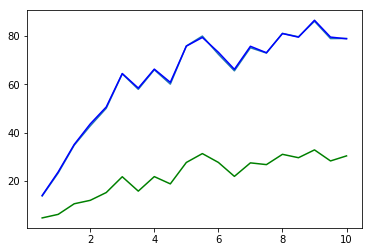

In [189]:
'''parse result for param search'''
print len(results)
avg_results = avg_res(results)
rs = [0.5* (x+1) for x in range(20)]
best_mag, best_num, best_k = defaultdict(int), defaultdict(int), defaultdict(int)
for r,k in avg_results:
    n,m,t = avg_results[r,k]
    if m > best_mag[r]:
        best_mag[r], best_k[r] = m, k
        best_num[r] = n
    
sorted_best_mag = sorted(best_mag.iteritems(), key=lambda x:x[0])
sorted_best_num = sorted(best_num.iteritems(), key=lambda x:x[0])
time_spent = [avg_results[r, best_k[r]][2] for r in rs]

print len(rs)
print len(sorted_best_mag)
print len(sorted_best_num)
# print time_spent
plt.plot(rs, [x[1] for x in sorted_best_num])
plt.plot(rs, [x[1] for x in sorted_best_mag], color='b')
plt.plot(rs, time_spent, color='green')

## Step 3: LSH Hashing

In [154]:
def P_trans(x):
    norm = np.linalg.norm(x)
    n = len(x)
    ret = np.zeros(n+pq_m * 2)
    ret[:n] = x
    for i in range(pq_m):
        ret[n+i] = norm ** (2 ** (i+1))
        ret[n+pq_m+i] = 0.5
    return ret

def Q_trans(x):
    norm = np.linalg.norm(x)
    n = len(x)
    ret = np.zeros(n+pq_m * 2)
    ret[:n]=x
    for i in range(pq_m):
        ret[n+i] = 0.5
        ret[n+pq_m+i] = norm ** (2 ** (i+1))
    return ret        

if mode == 'PQ':
    ptrans_vec = np.vectorize(P_trans, signature='(m)->(n)')
    X_ptrans = ptrans_vec(X_norm)
    print X_ptrans.shape

    qtrans_vec = np.vectorize(Q_trans, signature='(m)->(n)')
    X_qtrans = qtrans_vec(-1 * X_norm)
    print X_qtrans.shape

(5000, 28)
(5000, 28)


1.00115635977
8
102
97.237544 1250.0


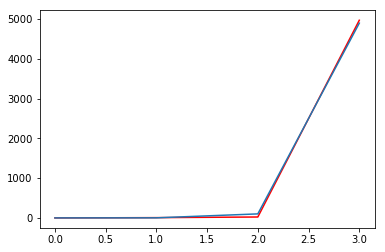

In [161]:
# def compute_intersection()
print np.average(np.linalg.norm(X_ptrans, axis=1))

r, k = .55,1
N, d = X_ptrans.shape
a, b= gen_ab(d, r, k)
P_hash_val, P_hash_bins = lsh(X_ptrans, a, b)
Q_hash_val, Q_hash_bins = lsh(X_qtrans, a, b)

# print P_hash_bins.keys()
print len(P_hash_bins[','.join(['0']*k)])
lengths_p = [len(l) for l in P_hash_bins.values()]
plt.plot(sorted(lengths_p), color='r')

# print Q_hash_bins.keys()
print len(Q_hash_bins[','.join(['0']*k)])
lengths_q = [len(l) for l in Q_hash_bins.values()]
plt.plot(sorted(lengths_q))

print eval_bin_intersection(P_hash_bins, Q_hash_bins)*100./N/N, avg_bin_size(P_hash_bins, Q_hash_bins)

In [167]:
'''heuristic 1: only look at pi's with exactly same hash value '''
def find_neg_dp_hash(X, P_hash_bins, Q_hash_val):
    start_time = time.time()
    N, k = Q_hash_val.shape
    ret = np.zeros((N,N))
    N_negs, N_compute = 0, 0
    for i in range(N):
        # for each query qi, find the bin of pi
        # only compute dot products with these pi's
        candidates = P_hash_bins[val_to_id(Q_hash_val[i])]
        N_compute += len(candidates)
        for j in candidates:
            dp = X[i].dot(X[j])
            if dp < 0:
                ret[i,j] = dp
                N_negs += 1
    end_time = time.time()
#     print("Compute {} dot products in {} seconds, found {} neg entries"\
#           .format(N_compute,end_time-start_time, N_negs))
    return ret ,end_time-start_time
        
hash_result = find_neg_dp_hash(X, P_hash_bins, Q_hash_val)

(array([ 109.,    0.,    0.,   12.,    0.,    0.,    1.,    0.,    0.,    1.]),
 array([ 1. ,  1.3,  1.6,  1.9,  2.2,  2.5,  2.8,  3.1,  3.4,  3.7,  4. ]),
 <a list of 10 Patch objects>)

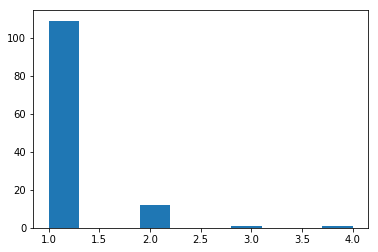

In [33]:
plt.hist(N_compute_each.values())

## Eval code

In [93]:
def find_negative_dot_product_bf(X):
    h, _ = X.shape
    ret = np.zeros((h,h))
    start_time = time.time()
    neg_entry = 0
    for i in range(h):
        for j in range(h):
            dotp = np.dot(X[i,:],X[j,:])
            if dotp < 0:
                neg_entry += 1
                ret[i,j] = dotp
    end_time = time.time()
    print("Compute {}*{} dot products in {} seconds, found {} neg entries"\
          .format(h,h,end_time-start_time, neg_entry))
    return ret

bf_result = find_negative_dot_product_bf(X)

Compute 5000*5000 dot products in 45.3091168404 seconds, found 1314674 neg entries


10% of mass lies before 0.935973480878% of entries(12305/1314674)
25% of mass lies before 3.26909941172% of entries(42978/1314674)
50% of mass lies before 13.9873459124% of entries(183888/1314674)
90% of mass lies before 72.8425449959% of entries(957642/1314674)
99% of mass lies before 97.0794280559% of entries(1276278/1314674)


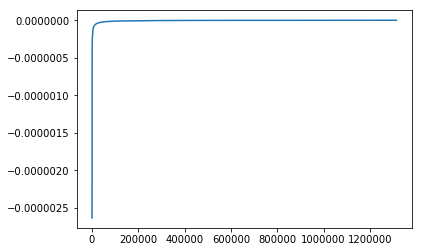

In [43]:
'''plot bf_result'''
negs = bf_result[bf_result<0]
plt.plot(sorted(negs))

percentages = [10,25,50,90,99]
k, i = 0, 0
s, ts = 0, np.sum(negs)
while k < len(percentages):
    p = percentages[k]
    if s <= 0.01 * p * ts:
        print "{}% of mass lies before {}% of entries({}/{})".format(p, 100.*i/len(negs),i, len(negs))
        k += 1
        continue
    s += negs[i]
    i += 1

In [41]:
'''heuristic 2 (the one used in paper):
for each qj, find pi with the most overlap in hash-values, compute until dp >= 0'''
def hash_intersect(h1, h2):
    return sum([1 if a==b else 0 for (a,b) in zip(h1,h2)])

N_compute_each = defaultdict(int)
def fndph2(X, P_hash_val, Q_hash_val):
    # TODO: precompute each qj label to best pi points
    def find_best_pi(j, seen):
        ''' i is index for qj'''
        best, best_score = -1, 0
        for i in range(N):
            if i in seen: continue
            score = hash_intersect(P_hash_val[i], Q_hash_val[j])
            if score > best_score and i not in seen:
                best, best_score = i, score
        return best
    start_time = time.time()
    N, k = Q_hash_val.shape
    ret = np.zeros((N,N))
    N_negs, N_compute = 0, 0
    for j in range(N):
        # for each query qj, iterate through pi
        seen = set()
        while True:
            i = find_best_pi(j, seen)
            if i == -1: break
            seen.add(i)
            dp = X[i].dot(X[j])
            if dp >= 0:
                break
            else:
                ret[i,j] = dp
                N_negs += 1
                N_compute += 1
                N_compute_each[j] += 1
    end_time = time.time()
    print("Compute {} dot products in {} seconds, found {} neg entries"\
          .format(N_compute,end_time-start_time, N_negs))
    return ret
    
k = 20
P_hash_val, P_hash_bins = lsh(X_ptrans, r=0.005, k=k)
Q_hash_val, Q_hash_bins = lsh(X_qtrans, r=25, k=k)
hr2 = fndph2(X, P_hash_val, Q_hash_val)

KeyboardInterrupt: 